## Импорты

In [ ]:
!pip install livelossplot
!pip install pymorphy2

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from livelossplot.inputs.tf_keras import PlotLossesCallback
print(tf.__version__)

import pickle
import pymorphy2
import ast

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,6)

file_path = '/content/drive/MyDrive/Colab Notebooks/Korus/nlp_tasks/find_assignee/data/'

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 9.4 MB/s 
2.7.0


In [ ]:
#@title Текстовые вспомогательные функции

# Очистка текста
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"www\S+", "")
    df[text_field] = df[text_field].str.replace(r"\[\S+\]", " ") #вставки картинок или ссылок
    df[text_field] = df[text_field].str.replace(r"ё", "е")
    df[text_field] = df[text_field].str.replace(r"[^А-Яа-яA-Za-z0-9.,!?@\\\-\'\_\s]+", " ") #всё лишнее убираем
    df[text_field] = df[text_field].str.replace(r"[\w.,!?@\\\'\`\"\_\-]*[0-9@]+[\w.,!?@\'\`\"\_\-]*", " ") #всё что с цифрами или @ убираем
    df[text_field] = df[text_field].str.replace(r"([,.!?])[\s\t\n]", r" \1 ") #чтобы знаки препинания делились как отдельные слова
    df[text_field] = df[text_field].str.replace(r"([.!?\|\\\'\`\"\_]){2,}", r" \1 ") # убрать повторяющиеся символы
    df[text_field] = df[text_field].str.replace(r"\s+", " ")
    df[text_field] = df[text_field].str.replace(r"( \.){2,}", " .")
    df[text_field] = df[text_field].str.strip()
    return df

#Лемматизация русских слов
morph = pymorphy2.MorphAnalyzer()
def tokenize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

#нормальная форма
def normal_form(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return ' '.join(res)


# Препроцессинг


In [ ]:


# file_name = 'find_assignee_010620-260421_validated.csv'
# find_assignee = pd.read_csv(file_path + file_name, sep=';', index_col='issue_number')

# # Объединяю source subject body в единый текст + лемматизация

# standardized_subject = standardize_text(find_assignee, 'subject').subject.astype(str).apply(normal_form)
# standardized_body = standardize_text(find_assignee, 'body').body.astype(str).apply(normal_form)

# tokens = ['<PAD>', '<SRC>', '<ATHR>', '<SBJCT>', '<BODY>', '<END>', '<UNKNOWN>']
# find_assignee['full_text'] = tokens[1] + ' ' + find_assignee['source'].astype(str) + ' ' \
#   + tokens[2] + ' ' + find_assignee['from'].astype(str) + ' ' \
#   + tokens[3] + ' ' + standardized_subject + ' ' \
#   + tokens[4] + ' ' + standardized_body + ' ' \
#   + tokens[5]
# find_assignee['full_text'] = find_assignee['full_text'].str.split()

# file_name = 'find_assignee_010620-260421_for_training.csv'
# find_assignee.to_csv(file_path + file_name, sep=';')

In [ ]:
#перезагрузить дф с нового файла
file_name = 'find_assignee_010620-260421_for_training.csv'
find_assignee = pd.read_csv(file_path + file_name, sep=';', index_col='issue_number')
find_assignee['full_text'] = find_assignee['full_text'].apply(ast.literal_eval)
find_assignee.head(3)


,source,from,subject,body,assignee,group,target_user,full_text
issue_number,,,,,,,,
HELPDESK-1301596,helpdesk@esphere.ru,metazon@ozon.ru,"ответ по заказу edi от юнилевер русь, ооо","поставщик юнилевер русь, ооо ответил по зака...",andreev.rv,edi,edi-hd,"[<SRC>, helpdesk@esphere.ru, <ATHR>, metazon@o..."
HELPDESK-1301579,jira@jiramail.esphere.ru,Elena.Aldaranova@guest.ferrero.com,загрузить recadv на,"татьяна, добрый день . просьба загрузить recad...",semenova.ts,edi,edi-hd,"[<SRC>, jira@jiramail.esphere.ru, <ATHR>, Elen..."
HELPDESK-1301548,helpdesk@esphere.ru,monitoring_bp@magnit.ru,exception . отсутствует статус доставки orders...,добрый день ! направляем вам отчет по edi доку...,naumov.ya,мониторинг,usc,"[<SRC>, helpdesk@esphere.ru, <ATHR>, monitorin..."


In [ ]:
# Создать словарь
def build_vocab(tokenized_texts, 
                max_words=20_000, 
                min_words_count=3, 
                add_tech_tokens=False):
    '''Умеет оставлять в словаре только max_words самых популярных слов. 
    min_words_count убирает редкие слова'''

    all_words = [word for tokens in tokenized_texts for word in tokens]
    vocab = {}
    for word in all_words:
      if word not in vocab:
        vocab[word] = 1
      else:
        vocab[word] += 1
    vocab = pd.DataFrame({'keys':vocab.keys(), 'values':vocab.values()})

    #Добавляю технические слова
    if isinstance(add_tech_tokens, (np.ndarray, list)):
      keys = add_tech_tokens
      values = list(range(999999,999999-len(add_tech_tokens), -1))
      special_words = pd.DataFrame({'keys':keys, 'values':values})
      vocab = pd.concat([vocab, special_words])
    elif add_tech_tokens == 'def':
      special_words = pd.DataFrame({'keys':["<PAD>", "<START>", "<UNKNOWN>"], 'values':[999999,999998,999997]})
      vocab = pd.concat([vocab, special_words])
    
    vocab.drop_duplicates(subset=['keys'], inplace=True, keep='last')
    print("%s words total, with max vocabulary size of %s" % (len(all_words), vocab.shape[0]))
    vocab = vocab[vocab['values'] >= min_words_count] \
      .sort_values(by='values', ascending=False) \
      .reset_index(drop=True).copy()
    # vocab.drop(columns='values', inplace=True)
    vocab = vocab[:max_words]
    print("Current vocabulary size is %s" % vocab.shape[0])

    vocab_idx_word_dict = vocab['keys'].to_dict()
    vocab_word_idx_dict = dict([(value, key) for (key, value) in vocab_idx_word_dict.items()])

    sentence_lengths = [len(tokens) for tokens in tokenized_texts]
    print("Max sentence length is %s" % max(sentence_lengths))
    return vocab, vocab_word_idx_dict, vocab_idx_word_dict

tokens = ['<PAD>', '<SRC>', '<ATHR>', '<SBJCT>', '<BODY>', '<END>', '<UNKNOWN>']
VOCAB, vocab_word_idx_dict, vocab_idx_word_dict = build_vocab(find_assignee.full_text.values, add_tech_tokens=tokens)

5998152 words total, with max vocabulary size of 83673
Current vocabulary size is 20000
Max sentence length is 3867


In [ ]:
# Кодировать целевой класс
label_enc = LabelEncoder()
find_assignee['class_label'] = label_enc.fit_transform(find_assignee.group)
labels = {}
for v, k in zip(label_enc.transform(label_enc.classes_), label_enc.classes_):
  print(v, k)
  labels[k] = v

0 bsr
1 eco
2 edi
3 edo
4 intgr
5 мониторинг
6 тандер


In [ ]:
# Кодировать текст
def encode_review(text, vocab_dict=vocab_word_idx_dict, pad=False):
    'text: pd.Series'
    idxs = [vocab_dict.get(word, vocab_dict['<UNKNOWN>']) for word in text]
    return idxs

def decode_review(encoded_text, vocab_dict=vocab_idx_word_dict):
    return ' '.join([vocab_dict.get(i, '?') for i in encoded_text])

find_assignee['encoded_text'] = find_assignee['full_text'].apply(encode_review)

In [ ]:
# padding
MAX_SEQ_LEN = 350

X = tf.keras.preprocessing.sequence.pad_sequences(
      find_assignee['encoded_text'].values,
      value=0,
      padding='post',
      maxlen=MAX_SEQ_LEN)


In [ ]:
#tts
X_train, X_valid, y_train, y_valid = train_test_split(X, find_assignee.class_label.values, test_size=0.15, random_state=64)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=64)

#class_weights
weights = dict([(k,find_assignee.shape[0] / v) for (k,v) in find_assignee.groupby(by='class_label').count().group.items()])
weights[6] = 15

# обучение

In [ ]:
EMB_SIZE = 256
VOCAB_SIZE = VOCAB.shape[0]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.SpatialDropout1D(0.8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.8)),
    tf.keras.layers.SpatialDropout1D(0.8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.8)),
    # tf.keras.layers.SpatialDropout1D(0.8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_SIZE, dropout=0.6)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    # tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.softmax),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 256)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1050624   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 512)               2

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

In [ ]:
file_path = "/content/drive/My Drive/saved_models/"
file_name = "epoch_{epoch:02d}_val_acc_{val_acc:.2f}.hdf5"
filepath = file_path + file_name

best_model = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_acc', 
    mode='max', 
    filepath=filepath, 
    save_best_only=True, 
    verbose=1
)

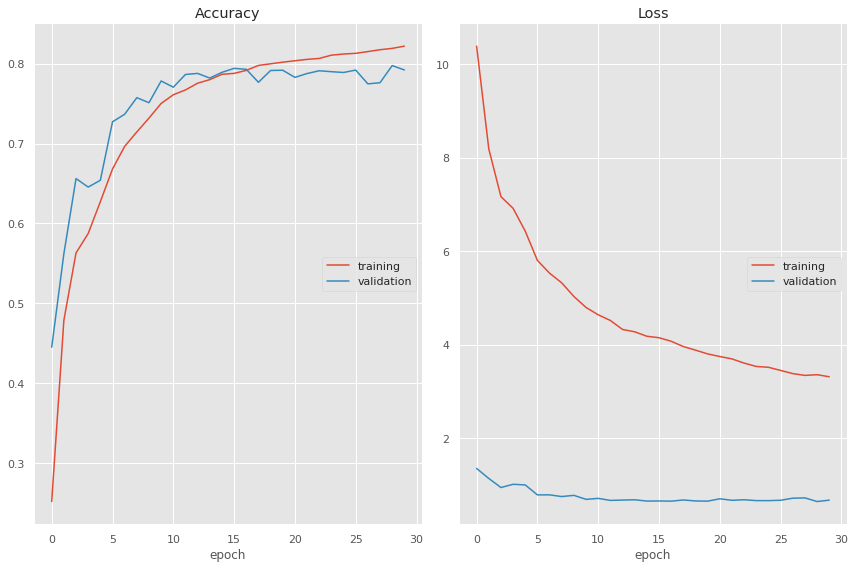

Accuracy
	training         	 (min:    0.252, max:    0.822, cur:    0.822)
	validation       	 (min:    0.445, max:    0.798, cur:    0.792)
Loss
	training         	 (min:    3.311, max:   10.382, cur:    3.311)
	validation       	 (min:    0.643, max:    1.350, cur:    0.672)


In [ ]:
# BATCH_SIZE = 512
# NUM_EPOCHS = 30

# history = model.fit(X_train,
#                     y_train,
#                     epochs=NUM_EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     validation_data=(X_test, y_test),
#                     verbose=1,
#                     class_weight=weights,
#                     callbacks=[best_model, PlotLossesCallback(), ])

In [ ]:
file_name = "epoch_29_val_acc_0.80.hdf5"
model = tf.keras.models.load_model(file_path + file_name)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 256)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        1050624   
 l)                                                              
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 512)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 512)        1574912   
 nal)                                                   

# Замерим скор

accuracy score 0.791


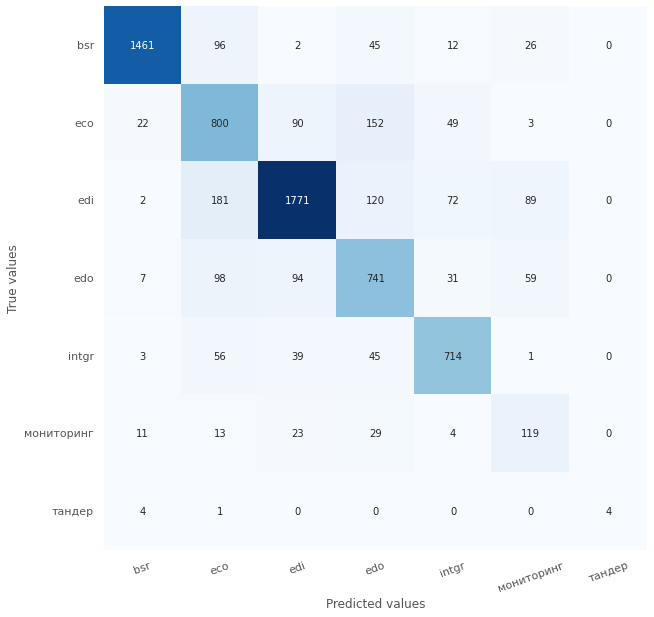

In [ ]:
y_pred = model.predict(X_valid)
print('accuracy score %.3f' % accuracy_score(y_valid, y_pred.argmax(axis=1)))
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(y_valid, y_pred.argmax(axis=1)), annot=True, cmap="Blues", cbar=False, square=True, fmt="d")
ax.set_xticklabels(labels.keys(), rotation=20)
ax.set_yticklabels(labels.keys(), rotation=0)
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values');


# 11.11.21 Попытка собрать примеры предсказаний


In [ ]:
outs = pd.DataFrame({'real_group':y_valid, 'probability':np.max(y_pred, axis=1), 'predicted_group':np.argmax(y_pred, axis=1)})

In [ ]:
outs['hit'] = outs.real_group == outs.predicted_group
outs

,real_group,probability,predicted_group,hit
0,6,0.873523,6,True
1,3,0.697891,3,True
2,3,0.899834,3,True
3,2,0.955314,2,True
4,2,0.923025,4,False
...,...,...,...,...
7084,0,0.656062,5,False
7085,2,0.993574,2,True
7086,2,0.997678,2,True
7087,4,0.970738,4,True


# Ввести ручную орбаботку для запросов с низкой уверенностью

С порогом уверенности 0.80 получается из пула 7089 запросов отправятся на ручную обработку 1997 (или 0.28)


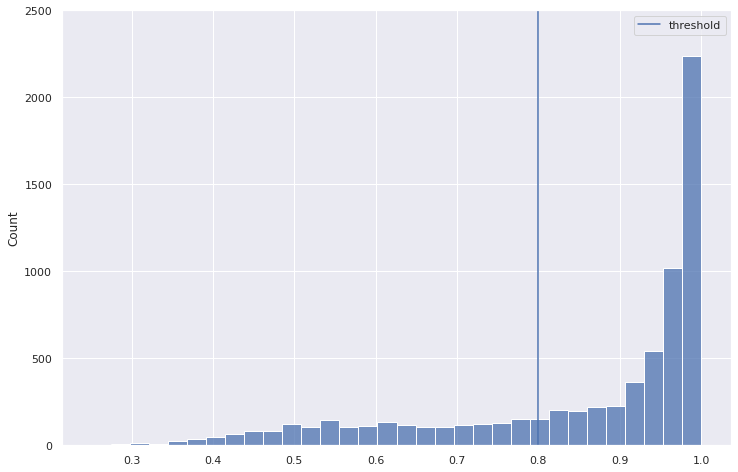

accuracy score 0.90 для уверенных предсказаний
accuracy score 0.51 для неуверенных


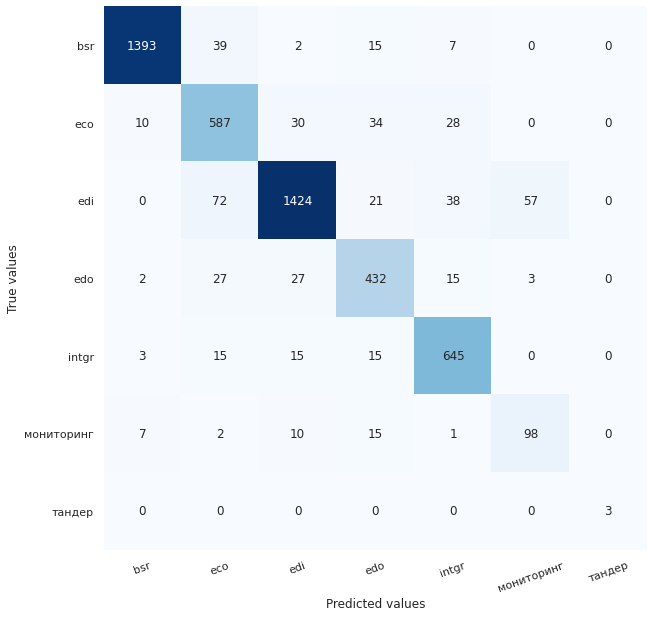

In [ ]:
threshold = 0.8

# 7 группа - на ручную обработку
targer_group = []
[targer_group.append(7) if i.max() <= threshold else targer_group.append(i.argmax()) for i in y_pred]
res = pd.DataFrame({'target_group':targer_group, 'probabilities':y_pred.tolist()})

print('С порогом уверенности %.2f получается из пула %d запросов отправятся на ручную обработку %d (или %.2f)' \
      % (threshold, 
         res.groupby('target_group').count().sum(), 
         res.groupby('target_group').count().iloc[7, 0],
         (res.groupby('target_group').count().iloc[7, 0] / res.groupby('target_group').count().sum()) ))

sns.set()
plt.figure(figsize=(12,8))
sns.histplot(y_pred.max(axis=1))
plt.plot([threshold, threshold], [0, 10000], 'b-', label='threshold')
plt.legend()
plt.ylim(0, 2500)
plt.show();

res['true'] = y_valid
res_auto = res.query('target_group != 7')
print('accuracy score %.2f для уверенных предсказаний' % accuracy_score(res_auto.true.values, res_auto.target_group.values))
res_manual = res.query('target_group == 7')
print('accuracy score %.2f для неуверенных' % accuracy_score(res_manual.true.values, res_manual.probabilities.apply(np.argmax)))
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(res_auto.true.values, res_auto.target_group.values), annot=True, cmap="Blues", cbar=False, square=True, fmt="d")
ax.set_xticklabels(labels.keys(), rotation=20)
ax.set_yticklabels(labels.keys(), rotation=0)
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values');
plt.show();

#Предварительный план реализации модели.
## Запуск возможен на любой python платформе локальной или облачной

1. Атворизоваться в jira по API
2. Опросить запросы, которые нужно назначить (есть JQL для этого)
3. Пропустить через ML модель, получить метки классов
4. по API назначить заявки в соответствии с метками
5. Добавить в jira поле, чтобы понимать какие уже орбаботаны:
 - назначен автоматически
 - назначен вручную
 - требует назначения

Для запуска в прод:
- протестить на некотором количестве продуктивных запросов
- накрутить цикличный таймер выполнения
- логирование
- прочее по стандартам разработки

Далее скорее всего нужно будет модифицировать процесс:
- написать дообучение
- накрутить выбор компонента
- накрутить интеграцию с срм, чтобы смотреть к какому направлению принадлежит Клиент

Построить график зависимости certain accuracy, uncertain accuracy, manual_ratio от threshold



- Провести АВ тестирование 50/50

